In [86]:
import os
import re
from matplotlib import ticker
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter, MultipleLocator


def complexity(method: str, ncodebooks: int, ncentroids: int, mode: str) -> float:
    if mode == "IDFT":
        M = 16
        D = 256
    else:
        M = 128
        D = 32
    if method.startswith("MAD") or method.startswith("Mithral"):
        return (800 * ncodebooks * M + 100 * D * np.log2(ncentroids)
                + 2.4 * M * ncodebooks * ncentroids)
    elif method.startswith("PQ"):
        return (6000 * D * ncentroids + 800 * ncodebooks * M - 2900 * ncentroids * ncodebooks
                + 2.4 * M * ncodebooks * ncentroids)
    elif method.startswith("Exact"):
        return 5500 * D * M



def complexityStor(method: str, ncodebooks: int, ncentroids: int, mode: str) -> float:
    if mode == "IDFT":
        M = 16
        D = 256
    else:
        M = 128
        D = 32
    if method.startswith("MAD"):
        return (M * ncodebooks * ncentroids)
    elif method.startswith("PQ"):
        return (6000 * D * ncentroids + 800 * ncodebooks * M - 2900 * ncentroids * ncodebooks
                + 1.2 * M * ncodebooks * ncentroids)
    elif method.startswith("Exact"):
        return 5500 * D * M


def evalNMSEroot(snr_: list, nmse_: list, refNMSE: float) -> float:
    """
    polyfit lg(nmse_) - lg(refNMSE) = f(snr_), and get the root of snr_
    """
    p = np.polyfit(snr_, np.log10(nmse_) - np.log10(refNMSE), deg=7)
    roots = np.roots(p)
    ammSNRs_ = roots[np.where(np.logical_and(np.isreal(roots), abs(roots) < 20))]
    assert len(ammSNRs_) == 1, "ammSNRs_ is : %s" % (ammSNRs_)
    return np.real(ammSNRs_[-1])


colors_ = ["r", "g", "b", "orange", "c", "m", "steelblue", "grey", "brown", "k"]
cbColors_ = {
    256: "C0",
    128: "C1",
    64: "C2",
    32: "C3",
}
markers_ = ["o", "x", "s", "d", "+", "*", "v", "^", ">", "D"]
cbColors_ = {
    1: "C0",
    2: "C1",
    4: "C2",
    8: "C3",
}
markers_ = ["1", "v", "o", "s", "*", "+", "x", "D", "|", "^", "2", ]
def minor_tick(x, pos):
    return "%.0f" % x


Exact
Mithral-IDFT(1,8)
0.8726817000865896
Mithral-IDFT(1,7)
0.947430114101989
Mithral-IDFT(1,6)
1.1289949895175546
Mithral-IDFT(2,8)
2.3067919823671375
Mithral-IDFT(2,7)
3.520231892506361
Mithral-IDFT(2,6)
8.789214377840505
{1: [(26.625454545454545, 0.8726817000865896, 8), (20.926363636363636, 0.947430114101989, 7), (18.02, 1.1289949895175546, 6)], 2: [(13.767272727272728, 2.3067919823671375, 8), (10.860909090909091, 3.520231892506361, 7), (9.35090909090909, 8.789214377840505, 6)]}


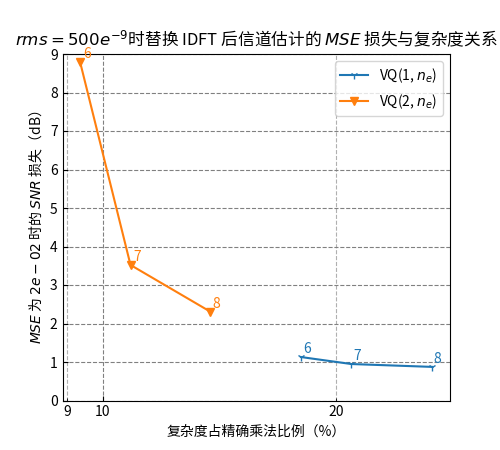

In [89]:
%matplotlib widget

RMS = 500 * 1e-9
mode = "IDFT"
thresh = 2e-2

if mode == "IDFT":
    D = 256
else:
    D = 32

fig, axLoss = plt.subplots(ncols=1, figsize=(5, 4.5))
if type(axLoss) == list:
    axLoss = axLoss[0]
plt.rcParams["font.sans-serif"] = ["Source Han Sans CN"]
plt.rcParams["font.size"] = ["20"]
axLoss.set_title(r"$rms=%.0fe^{-9}$时替换 %s 后信道估计的 $MSE$ 损失与复杂度关系" % (RMS*1e9, mode))
axLoss.set_xlabel(r"复杂度占精确乘法比例（%）")
axLoss.set_ylabel(r"$MSE$ 为 $%.0e$ 时的 $SNR$ 损失（dB）" % thresh)
axLoss.xaxis.set_tick_params(direction='in', which='both')  # 刻度线向内
axLoss.yaxis.set_tick_params(direction='in', which='both')
axLoss.grid(True, which="major", ls="--", color="grey")
axLoss.grid(True, which="minor", ls="--")
axLoss.set_xscale("log")
# axLoss.xaxis.set_major_locator(MultipleLocator(1.0))
# axLoss.yaxis.set_major_locator(MultipleLocator(1.0))
axLoss.xaxis.set_minor_formatter(FuncFormatter(minor_tick))
axLoss.xaxis.set_major_formatter(FuncFormatter(minor_tick))

path = "./dft/"
files_ = os.listdir(path)
files_.sort(reverse=True)
colorCnt = 7
exactSNR = 0
maxLoss = 0

plots_ = {}

for file in files_:
    match = None
    try:
        # if match == None:
        #     match = re.match(r"\+[0-9][a-z,A-Z].*?\.csv", file)
        # if match == None:
        #     match = re.match(r"\+\+\+[0-9][a-z,A-Z].*?\.csv", file)
        if match == None:
            if abs(RMS - 75*1e-9) < 1e-16:
                match = re.match(r"\+DFT75\+.*?\.csv", file)
            if abs(RMS - 500*1e-9) < 1e-16:
                match = re.match(r"\+DFT\+.*?\.csv", file)

        if match != None:

            fin = open(path + file, "r")
            lines_ = fin.readlines()

            ncodebooks = int(lines_[13].split(",")[1].strip())
            ncentroids = int(lines_[14].split(",")[1].strip())
            nbits = lines_[16].split(",")[1].strip()
            method = lines_[18][14:].strip().strip('\"')
            if mode == "IDFT":
                if method.find("-DFT") != -1:
                    continue
            elif mode == "DFT":
                ncodebooks = ncodebooks // 256 * 32
                if method.find("-IDFT") != -1:
                    continue
            print(method)
            # if method.startswith("Mithral"):
            #     method = "MAD-(K=" + str(ncentroids) + " C=" + str(ncodebooks) + ")" + method[7:]
            curColor = colors_[colorCnt]
            curLine = "-"
            if method.startswith("Exact"):
                curColor = "k"
                curLine = "-."
            if method.startswith("SQ"):
                curLine = "-."
            if method.startswith("PQ"):
                curLine = ":"
                continue
            if int(nbits) <= 8 and method.startswith("MAD"):
                continue
            # if (int(nbits) <= 8 or int(nbits) > 16) and method.startswith("MAD"):
            #     continue
            snr_ = []
            ber_ = []
            rawNMSE_ = []
            for line in lines_[20:]:
                try:
                    snr_.append(float(line.split(",")[0]))
                    if float(line.split(",")[1]) == 0:
                        ber_.append(None)
                    else:
                        ber_.append(float(line.split(",")[1]))
                    rawNMSE_.append(float(line.split(",")[6]))
                except:
                    break

            if method.startswith("Exact"):
                exactSNR = evalNMSEroot(snr_, rawNMSE_, thresh)
            if method.startswith("Mithral"):
                # method += "-"+nbits+"bits"
                ammSNR = evalNMSEroot(snr_, rawNMSE_, thresh)
                loss = ammSNR - exactSNR
                if loss > maxLoss:
                    maxLoss = loss
                comp = complexity(method, ncodebooks, ncentroids, mode) / (5500 * 256 * 16) * 100
                # axLoss.scatter(comp, loss, c=cbColors_[ncodebooks],
                #                marker=markers_[colorCnt], label=method)
                # axLoss.text(comp+0.1, loss+0.1, int(np.log2(ncentroids)), fontsize=10,)
                if D // ncodebooks not in plots_:
                    plots_[D//ncodebooks] = []
                plots_[D//ncodebooks].append((comp, loss, int(np.log2(ncentroids))))
                print(loss)
                colorCnt -= 1
    except Exception as e:
        print(file + ": ", e)

print(plots_)
cnt = 0
# plots[x][0]: (comp, loss, int(np.log2(ncentroids)))
for x in plots_.keys():
    plots_[x].sort()
    x_ = []
    y_ = []
    i = 0
    while i < len(plots_[x]):
        if i > 0 and plots_[x][i-1][0] == plots_[x][i][0] and plots_[x][i-1][1] < plots_[x][i][1]:
            plots_[x].pop(i)
        else:
            x_.append(plots_[x][i][0])
            y_.append(plots_[x][i][1])
            axLoss.text(plots_[x][i][0]+0.1, plots_[x][i][1]+0.1, plots_[x][i][2], fontsize=10, color=cbColors_[x])
            i += 1
    axLoss.plot(x_, y_, c=cbColors_[x], label=r"VQ(%d, $n_e$)" % x, marker=markers_[cnt])
    cnt += 1

axLoss.legend()
axLoss.set_ylim(top=np.ceil(maxLoss), bottom=0)
plt.show()
plt.savefig("Comp%srms%.0f.svg" % (mode, RMS*1e9))

Exact
Mithral-IDFT(1,8)
0.28751349413801996
Mithral-IDFT(1,7)
0.23315790761336963
Mithral-IDFT(1,6)
0.1927143943467975
Mithral-IDFT(1,5)
0.6200837795708765
Mithral-IDFT(2,8)
0.9223158195089596
Mithral-IDFT(2,7)
1.1623816718857753
Mithral-IDFT(4,8)
2.1159257018380426
{1: [(26.625454545454545, 0.28751349413801996, 8), (20.926363636363636, 0.23315790761336963, 7), (18.02, 0.1927143943467975, 6), (16.509999999999998, 0.6200837795708765, 5)], 2: [(13.767272727272728, 0.9223158195089596, 8), (10.860909090909091, 1.1623816718857753, 7)], 4: [(7.338181818181819, 2.1159257018380426, 8)]}


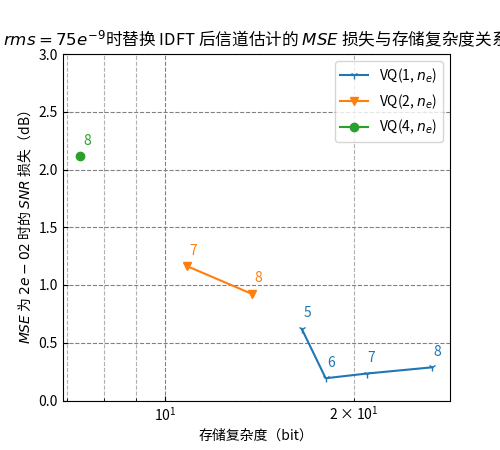

In [88]:
%matplotlib widget

RMS = 75 * 1e-9
mode = "IDFT"
thresh = 2e-2

if mode == "IDFT":
    D = 256
else:
    D = 32

fig, axLoss = plt.subplots(ncols=1, figsize=(5, 4.5))
if type(axLoss) == list:
    axLoss = axLoss[0]
plt.rcParams["font.sans-serif"] = ["Source Han Sans CN"]
axLoss.set_title(r"$rms=%.0fe^{-9}$时替换 %s 后信道估计的 $MSE$ 损失与存储复杂度关系" % (RMS*1e9, mode))
axLoss.set_xlabel(r"存储复杂度（bit）")
axLoss.set_ylabel(r"$MSE$ 为 $%.0e$ 时的 $SNR$ 损失（dB）" % thresh)
axLoss.xaxis.set_tick_params(direction='in', which='both')  # 刻度线向内
axLoss.yaxis.set_tick_params(direction='in', which='both')
axLoss.grid(True, which="major", ls="--", color="grey")
axLoss.grid(True, which="minor", ls="--")
axLoss.set_xscale("log")

path = "./dft/"
files_ = os.listdir(path)
files_.sort(reverse=True)
colorCnt = 7
exactSNR = 0
maxLoss = 0

plots_ = {}

for file in files_:
    match = None
    try:
        # if match == None:
        #     match = re.match(r"\+[0-9][a-z,A-Z].*?\.csv", file)
        # if match == None:
        #     match = re.match(r"\+\+\+[0-9][a-z,A-Z].*?\.csv", file)
        if match == None:
            if abs(RMS - 75*1e-9) < 1e-16:
                match = re.match(r"\+DFT75\+.*?\.csv", file)
            if abs(RMS - 500*1e-9) < 1e-16:
                match = re.match(r"\+DFT\+.*?\.csv", file)

        if match != None:

            fin = open(path + file, "r")
            lines_ = fin.readlines()

            ncodebooks = int(lines_[13].split(",")[1].strip())
            ncentroids = int(lines_[14].split(",")[1].strip())
            nbits = lines_[16].split(",")[1].strip()
            method = lines_[18][14:].strip().strip('\"')
            if mode == "IDFT":
                if method.find("-DFT") != -1:
                    continue
            elif mode == "DFT":
                ncodebooks = ncodebooks // 256 * 32
                if method.find("-IDFT") != -1:
                    continue
            print(method)
            # if method.startswith("Mithral"):
            #     method = "MAD-(K=" + str(ncentroids) + " C=" + str(ncodebooks) + ")" + method[7:]
            curColor = colors_[colorCnt]
            curLine = "-"
            if method.startswith("Exact"):
                curColor = "k"
                curLine = "-."
            if method.startswith("SQ"):
                curLine = "-."
            if method.startswith("PQ"):
                curLine = ":"
                continue
            if int(nbits) <= 8 and method.startswith("MAD"):
                continue
            # if (int(nbits) <= 8 or int(nbits) > 16) and method.startswith("MAD"):
            #     continue
            snr_ = []
            ber_ = []
            rawNMSE_ = []
            for line in lines_[20:]:
                try:
                    snr_.append(float(line.split(",")[0]))
                    if float(line.split(",")[1]) == 0:
                        ber_.append(None)
                    else:
                        ber_.append(float(line.split(",")[1]))
                    rawNMSE_.append(float(line.split(",")[6]))
                except:
                    break

            if method.startswith("Exact"):
                exactSNR = evalNMSEroot(snr_, rawNMSE_, thresh)
            if method.startswith("Mithral"):
                # method += "-"+nbits+"bits"
                ammSNR = evalNMSEroot(snr_, rawNMSE_, thresh)
                loss = ammSNR - exactSNR
                if loss > maxLoss:
                    maxLoss = loss
                comp = complexity(method, ncodebooks, ncentroids, mode) / (5500 * 256 * 16) * 100
                # axLoss.scatter(comp, loss, c=cbColors_[ncodebooks],
                #                marker=markers_[colorCnt], label=method)
                # axLoss.text(comp+0.1, loss+0.1, int(np.log2(ncentroids)), fontsize=10,)
                if D // ncodebooks not in plots_:
                    plots_[D//ncodebooks] = []
                plots_[D//ncodebooks].append((comp, loss, int(np.log2(ncentroids))))
                print(loss)
                colorCnt -= 1
    except Exception as e:
        print(file + ": ", e)

print(plots_)
cnt = 0
# plots[x][0]: (comp, loss, int(np.log2(ncentroids)))
for x in plots_.keys():
    plots_[x].sort()
    x_ = []
    y_ = []
    i = 0
    while i < len(plots_[x]):
        if i > 0 and plots_[x][i-1][0] == plots_[x][i][0] and plots_[x][i-1][1] < plots_[x][i][1]:
            plots_[x].pop(i)
        else:
            x_.append(plots_[x][i][0])
            y_.append(plots_[x][i][1])
            axLoss.text(plots_[x][i][0]+0.1, plots_[x][i][1]+0.1, plots_[x][i][2], fontsize=10, color=cbColors_[x])
            i += 1
    axLoss.plot(x_, y_, c=cbColors_[x], label=r"VQ(%d, $n_e$)" % x, marker=markers_[cnt])
    cnt += 1

axLoss.legend()
axLoss.set_ylim(top=np.ceil(maxLoss), bottom=0)
plt.show()
plt.savefig("Comp%srms%.0f.svg" % (mode, RMS*1e9))